In [ ]:
# ref: workshop code

inertial_input = Input(shape=(107,6),name="iner_lstm_input")
iner_lstm_1 = LSTM(50,input_shape=(107,6),return_sequences=True)(inertial_input)
iner_lstm_out = LSTM(100,return_sequences=False)(iner_lstm_1)
iner_dense = Dense(50)(iner_lstm_out)
inertial_out = Dense(output_dim=28, name="inertial_output")(iner_dense)

skeleton_input = Input(shape=(41,60),name="ske_lstm_input")
ske_lstm_1 = LSTM(128,input_shape=(41,60),return_sequences=True)(skeleton_input)
ske_lstm_out = LSTM(256,return_sequences=False)(ske_lstm_1)
ske_dense = Dense(128)(ske_lstm_out)
skeleton_out = Dense(output_dim=28, name="skeleton_output")(ske_dense)

merge = keras.layers.concatenate([iner_lstm_out, ske_lstm_out])

dense_1 = Dense(128, activation = 'relu')(merge)
#dense_2 = Dense(128, activation = 'relu')(dense_1)
main_output = Dense(output_dim=28, activation='softmax', name='main_output')(dense_1)

model = Model(inputs=[inertial_input,skeleton_input],outputs=[main_output,inertial_out,skeleton_out] )
model.compile(loss='mse',optimizer='rmsprop',metrics=['mae', 'acc'])

In [ ]:
# ref: https://blog.goodaudience.com/predicting-physical-activity-based-on-smartphone-sensor-data-using-cnn-lstm-9182dd13b6bc

model = Sequential()
model.add(Merge([first_model, second_model, third_model], mode='concat'))
model.add(Dropout(0.4))
model.add(Dense(n_classes))
model.add(BatchNormalization())
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
history = model.fit([X_trainS1, X_trainS2, X_trainS3], Y_train,
                    batch_size=batch_size,
                    validation_data=([X_valS1, X_valS2, X_valS3], Y_val),epochs=epochs)

## Prepare data

In [1]:
import numpy as np
from scipy.io import loadmat
from keras.preprocessing import sequence
from keras.utils import to_categorical

X_train = []
Y_train = []
X_val = []
Y_val = []
X_test = []
Y_test = []

for action in range(1, 28):
    # print(action)
    for subject in range(1, 9):
        for trial in range(1, 5):
            # data = import_inertial_data(action, subject, trial)
            filename = f'Inertial/a{action}_s{subject}_t{trial}_inertial.mat'
            try:
                data = loadmat(filename)['d_iner']
            except:
                continue
            
            # if data is None: continue
            data = np.swapaxes(data, 0, 1)
            data = sequence.pad_sequences(data, maxlen=326)

            if subject in [1, 2 ,3, 5] :
                X_train.append(data)
                Y_train.append(action-1)
            elif subject in [6, 7]:
                X_val.append(data)
                Y_val.append(action-1)
            else:
                X_test.append(data)
                Y_test.append(action-1)
                
X_train1 = np.array(X_train)
Y_train = np.array(Y_train)
X_val1 = np.array(X_val)
Y_val = np.array(Y_val)
X_test1 = np.array(X_test)
Y_test = np.array(Y_test)
Y_label = Y_test
X_train1 = np.swapaxes(X_train1, 1, 2)
X_val1 = np.swapaxes(X_val1, 1, 2)
X_test1 = np.swapaxes(X_test1, 1, 2)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
Y_val = to_categorical(Y_val)

print('X_train.shape:', X_train1.shape)
print('Y_train.shape:', Y_train.shape)
print('X_val.shape:', X_val1.shape)
print('Y_val.shape:', Y_val.shape)
print('X_test.shape:', X_test1.shape)
print('Y_test.shape:', Y_test.shape)

Using TensorFlow backend.


X_train.shape: (431, 326, 6)
Y_train.shape: (431, 27)
X_val.shape: (215, 326, 6)
Y_val.shape: (215, 27)
X_test.shape: (215, 326, 6)
Y_test.shape: (215, 27)


In [2]:
from cv2 import resize

X_train = []
X_val = []
X_test = []

for action in range(1, 28):
    # print(action)
    for subject in range(1, 9):
        for trial in range(1, 5):
            # data = import_inertial_data(action, subject, trial)
            filename = f'Skeleton/a{action}_s{subject}_t{trial}_skeleton.mat'
            try:
                data = loadmat(filename)['d_skel']
            except:
                continue
            
            # not right
            # data = data.reshape(60, data.shape[2])
            data2 = data[:,0,:]
            for n in range(1,3):
                data2 = np.vstack((data2, data[:,n,:]))
            data = data2
            
            # normalize coord into image pixel
            data = np.floor((data-data.min()) / (data.max()-data.min()) * 255) 
            data = resize(data, (60, 60))
            # data = sequence.pad_sequences(data, maxlen=125)
            if subject in [1, 2 ,3, 5] :
                X_train.append(data)
                # Y_train.append(action-1)
            elif subject in [6, 7]:
                X_val.append(data)
                # Y_val.append(action-1)
            else:
                X_test.append(data)
                # Y_test.append(action-1)
                
X_train2 = np.array(X_train)
X_val2 = np.array(X_val)
X_test2 = np.array(X_test)

X_train2 = np.expand_dims(X_train2, axis=3)
X_test2 = np.expand_dims(X_test2, axis=3)
X_val2 = np.expand_dims(X_val2, axis=3)

print('X_train.shape:', X_train2.shape)
print('Y_train.shape:', Y_train.shape)
print('X_val.shape:', X_val2.shape)
print('Y_val.shape:', Y_val.shape)
print('X_test.shape:', X_test2.shape)
print('Y_test.shape:', Y_test.shape)

X_train.shape: (431, 60, 60, 1)
Y_train.shape: (431, 27)
X_val.shape: (215, 60, 60, 1)
Y_val.shape: (215, 27)
X_test.shape: (215, 60, 60, 1)
Y_test.shape: (215, 27)


In [3]:
mat_depth = np.load('depth_of.npz')
mat_video = np.load('video_of.npz')

X_train3 = mat_depth['arr_0']
X_val3 = mat_depth['arr_2']
X_test3 = mat_depth['arr_4']
X_train4 = mat_video['arr_0']
X_val4 = mat_video['arr_2']
X_test4 = mat_video['arr_4']

print(X_train3.shape)
print(X_val3.shape)
print(X_test3.shape)
print(X_train4.shape)
print(X_val4.shape)
print(X_test4.shape)

(431, 64, 64, 20)
(215, 64, 64, 20)
(215, 64, 64, 20)
(431, 64, 64, 20)
(215, 64, 64, 20)
(215, 64, 64, 20)


## Multimodal fusion - rm dropouts


In [7]:
kernel_size = 3 
pool_size = 2
dropout_rate = 0.6
f_act = 'relu'
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv1D, Conv2D, Dropout, Flatten, Activation, Dense, LSTM, Input, concatenate
from keras.layers.pooling import MaxPooling1D, MaxPooling2D
from keras.models import Model

from keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopper = EarlyStopping(patience=5, verbose=1, monitor='val_acc')
checkpointer = ModelCheckpoint('model_f.h5', verbose=0, save_best_only=True)



simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape = (64, 64, 20), 
                                  name = 'NormalizeInput'))
simple_cnn.add(Conv2D(64, kernel_size = (3,3), activation='relu', padding='same'))
simple_cnn.add(MaxPooling2D((2, 2) , strides = 2))
simple_cnn.add(Conv2D(128, kernel_size = (3,3), activation='relu', padding='same'))
simple_cnn.add(MaxPooling2D((2, 2) , strides = 2))
simple_cnn.add(Conv2D(256, kernel_size = (3,3), activation='relu', padding='same'))
simple_cnn.add(MaxPooling2D((2, 2) , strides = 2))
simple_cnn.add(Conv2D(256, kernel_size = (3,3), activation='relu', padding='same'))
simple_cnn.add(MaxPooling2D((2, 2) , strides = 2))
simple_cnn.add(Flatten())
# 256 for testing, otherwise use 2048
simple_cnn.add(Dense(1024, activation='relu'))
simple_cnn.add(Dropout(dropout_rate))



simple_cnn2 = Sequential()
simple_cnn2.add(BatchNormalization(input_shape = (64, 64, 20), 
                                  name = 'NormalizeInput'))
simple_cnn2.add(Conv2D(64, kernel_size = (3,3), activation='relu', padding='same'))
simple_cnn2.add(MaxPooling2D((2, 2) , strides = 2))
simple_cnn2.add(Conv2D(128, kernel_size = (3,3), activation='relu', padding='same'))
simple_cnn2.add(MaxPooling2D((2, 2) , strides = 2))
simple_cnn2.add(Conv2D(256, kernel_size = (3,3), activation='relu', padding='same'))
simple_cnn2.add(MaxPooling2D((2, 2) , strides = 2))
simple_cnn2.add(Conv2D(256, kernel_size = (3,3), activation='relu', padding='same'))
simple_cnn2.add(MaxPooling2D((2, 2) , strides = 2))
simple_cnn2.add(Flatten())
# 256 for testing, otherwise use 2048
simple_cnn2.add(Dense(1024, activation='relu'))
simple_cnn2.add(Dropout(dropout_rate))


# kernel_size = 3 
# pool_size = 2
# dropout_rate = 0.15
# f_act = 'relu'

model1 = Sequential()
model1.add(Conv1D(64, (kernel_size), input_shape=X_train1.shape[1:], 
                       activation=f_act, padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling1D(pool_size=(pool_size)))
# model1.add(Dropout(dropout_rate))

model1.add(Conv1D(64, (kernel_size), activation=f_act, padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling1D(pool_size=(pool_size)))
# model1.add(Dropout(dropout_rate))

model1.add(Conv1D(64, (kernel_size), activation=f_act, padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling1D(pool_size=(pool_size)))

model1.add(Conv1D(64, (kernel_size), activation=f_act, padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling1D(pool_size=(pool_size)))
#model1.add(Dropout(dropout_rate)
# model1.add(LSTM(128, return_sequences=True))
model1.add(LSTM(128, return_sequences=True))
model1.add(LSTM(128))
model1.add(Dropout(dropout_rate))


model2 = Sequential()
model2.add(BatchNormalization(input_shape = X_train2.shape[1:], 
                                  name = 'NormalizeInput'))
model2.add(Conv2D(32, kernel_size = (3,3), activation='relu'))
model2.add(MaxPooling2D((3, 3) , strides = 2))
model2.add(Conv2D(32, kernel_size = (3,3), activation='relu'))
model2.add(MaxPooling2D((3, 3) , strides = 2))
model2.add(Conv2D(64, kernel_size = (3,3), activation='relu'))
model2.add(MaxPooling2D((3, 3) , strides = 2))
model2.add(Conv2D(64, kernel_size = (3,3), activation='relu'))
model2.add(Flatten())
model2.add(Dropout(dropout_rate))
# create tensors
inertial_input = Input(shape=(326, 6))
encoded_int = model1(inertial_input)
#encoded_int_out = encoded_int.add(keras.layers.Dropout(0.5))
skeleton_input = Input(shape=(60, 60, 1))
encoded_skt = model2(skeleton_input)
depth_input = Input(shape=(64, 64, 20))
encoded_dpt = simple_cnn(depth_input)
video_input = Input(shape=(64, 64, 20))
encoded_vd = simple_cnn2(video_input)

merged = concatenate([encoded_int, encoded_skt, encoded_dpt, encoded_vd])
output = Dense(27, activation='softmax')(merged)
model = Model(inputs=[inertial_input, skeleton_input, depth_input, video_input], outputs=output)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



history = model.fit([X_train1, X_train2, X_train3, X_train4], Y_train,
                    batch_size=64,
                    validation_data=([X_val1, X_val2, X_val3, X_val4], Y_val), 
                    epochs=30, verbose = 2, 
                    callbacks = [earlystopper, checkpointer])

Train on 431 samples, validate on 215 samples
Epoch 1/30
 - 47s - loss: 5.0401 - acc: 0.0348 - val_loss: 3.3613 - val_acc: 0.0930
Epoch 2/30
 - 38s - loss: 3.2039 - acc: 0.1230 - val_loss: 3.0010 - val_acc: 0.2884
Epoch 3/30
 - 40s - loss: 2.7413 - acc: 0.2831 - val_loss: 2.4476 - val_acc: 0.3163
Epoch 4/30
 - 37s - loss: 2.2019 - acc: 0.3735 - val_loss: 1.8767 - val_acc: 0.5256
Epoch 5/30
 - 40s - loss: 1.4867 - acc: 0.6589 - val_loss: 1.4955 - val_acc: 0.5209
Epoch 6/30
 - 38s - loss: 1.0236 - acc: 0.7262 - val_loss: 1.1200 - val_acc: 0.6698
Epoch 7/30
 - 38s - loss: 0.5831 - acc: 0.8353 - val_loss: 0.7045 - val_acc: 0.7674
Epoch 8/30
 - 41s - loss: 0.3383 - acc: 0.9095 - val_loss: 0.6284 - val_acc: 0.7953
Epoch 9/30
 - 38s - loss: 0.2160 - acc: 0.9443 - val_loss: 0.6114 - val_acc: 0.7860
Epoch 10/30
 - 34s - loss: 0.1293 - acc: 0.9745 - val_loss: 0.6677 - val_acc: 0.7907
Epoch 11/30
 - 34s - loss: 0.1141 - acc: 0.9722 - val_loss: 0.5652 - val_acc: 0.8047
Epoch 12/30
 - 34s - loss: 0

In [8]:
# Evaluate model
scores = model.evaluate([X_test1, X_test2, X_test3, X_test4], Y_test, verbose=1)
print("Loss: %.2f" % scores[0])
print("Accuracy: %.2f%%" % (scores[1]*100))

215/215 [==============================] - 15s 69ms/step
Loss: 0.61
Accuracy: 83.72%


In [9]:
from keras.models import load_model

model_best = load_model('model_f.h5')
loss, acc = model_best.evaluate([X_test1, X_test2, X_test3, X_test4], Y_test, verbose = 1)
                                
print("loss: %.3f" % (loss))
print("acc: %.3f" % (acc))

215/215 [==============================] - 14s 63ms/step
loss: 0.550
acc: 0.819


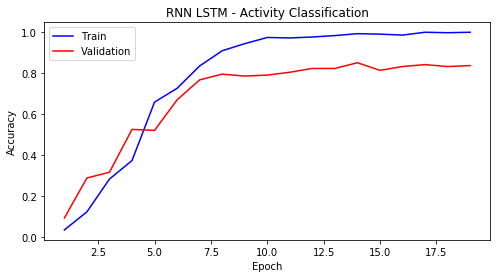

In [11]:
import matplotlib.pyplot as plt

epoch = list(range(1,20))
plt.figure(figsize=(8,4))
plt.plot(epoch, history.history['acc'], color='b')
plt.plot(epoch, history.history['val_acc'], color='r')
plt.title('RNN LSTM - Activity Classification')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(('Train', 'Validation'))
plt.show()

In [13]:
pred = model.predict([X_test1, X_test2, X_test3, X_test4], batch_size=64, verbose = 2)
pred[5]

array([9.8494577e-01, 1.2983007e-02, 6.4523381e-05, 1.6077032e-05,
       6.1448713e-06, 1.5226176e-05, 4.1579685e-07, 8.6311287e-05,
       5.7898102e-05, 2.9576506e-05, 2.7172834e-07, 7.4413634e-07,
       2.1456394e-04, 1.6207880e-04, 2.3846780e-05, 1.3330730e-05,
       1.0463455e-06, 1.0963621e-04, 6.0284101e-06, 1.1912440e-05,
       1.5029393e-07, 2.7693566e-06, 2.5742198e-04, 3.6372698e-04,
       5.5653222e-06, 2.6481632e-05, 5.9550017e-04], dtype=float32)

In [14]:
y_class = pred.argmax(axis=-1)
y_class[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

In [15]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(Y_label, y_class)
cnf_matrix.shape

(27, 27)

In [16]:
# https://stackoverflow.com/questions/38971293/get-class-labels-from-keras-functional-model

import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


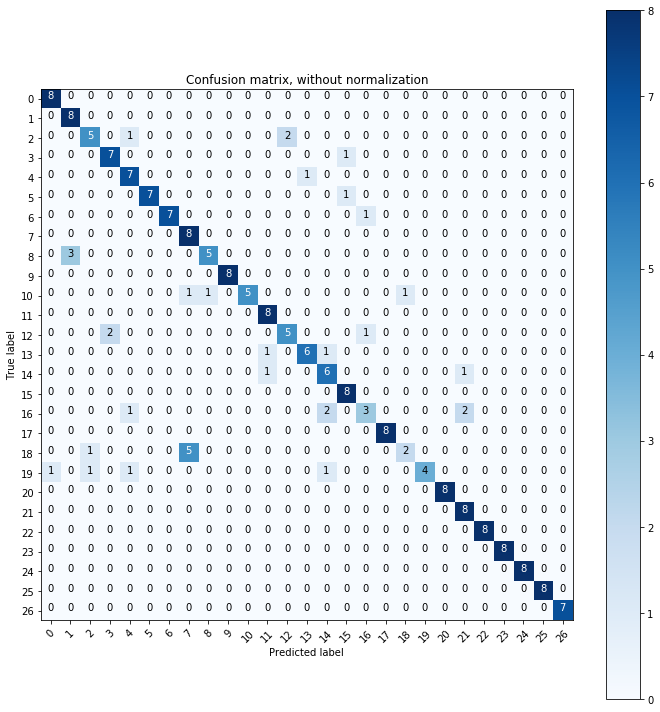

In [17]:
# Plot Model 2, to be renewed

class_names = list(range(27))

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

epoch = list(range(1,22))
plt.figure(figsize=(8,4))
plt.plot(epoch, history.history['acc'], color='b')
plt.plot(epoch, history.history['val_acc'], color='r')
plt.title('RNN LSTM - Activity Classification')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(('Train', 'Validation'))
plt.show()

In [ ]:
pred = model.predict([X_test1, X_test2, X_test3, X_test4], batch_size=64, verbose = 2)
pred[5]

In [ ]:
y_class = pred.argmax(axis=-1)
y_class[:10]

In [ ]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(Y_label, y_class)
cnf_matrix.shape

In [ ]:
# https://stackoverflow.com/questions/38971293/get-class-labels-from-keras-functional-model

import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
# Plot Model 2, to be renewed

class_names = list(range(27))

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()